In [25]:
import numpy as np
np.bool = np.bool_
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib as mt
import matplotlib.pyplot as plt
import MDAnalysis as mda
import sys
sys.path.append('../0_python_modules/')
import msm_analysis as ana

In [2]:
colors = np.array(['salmon', 'dodgerblue', 'teal', 'limegreen', 'sienna', 'violet'])
cmaps = [mt.colors.LinearSegmentedColormap.from_list('', colors[:i], N=i) for i in range(3, 7)]

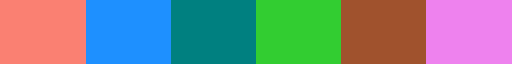

In [3]:
cmaps[3]

In [5]:
trajs = np.array([
    f'LONG_TRAJ/{i}.xtc' for i in ['1f','2_2','2f_1','3_1','3_2','4f','5f']
] + [
    f'SHORT_TRAJ_subunit1/{i}.xtc' for i in range(1,63)
] + [
    f'SHORT_TRAJ_subunit2/{i}.xtc' for i in range(1,41)
] + [
    f'SHORT_TRAJ_intermediate/{i}.xtc' for i in range(1,21)
])
path = '../1_datasets/mopR_bindings/'
pdb = 'p2e.pdb'

In [6]:
def get_frames(model, mdis, dtrj, stds, 
               microstate='large', trj='most'):
    xtcs = []
    frames = []
    for a,macro in enumerate(mdis):
        if microstate=='large':
            micro = macro[ stds[macro].argmax() ]
        else:
            micro = macro[ stds[macro].argmin() ]
            
        nframes = [np.where(dd==micro)[0].shape[0] for dd in dtrj]
        if trj=='most':
            dd = np.argmax(nframes)
        else:
            dd = np.argmin(nframes)
            
        frames.append( np.where(dtrj[dd] == micro)[0] )
        xtcs.append(dd)
        
    return xtcs, frames


def write_frames(path, pdb, trajs, idata,
                tid, fid, nconfs=10, otype='random', sel='all',
                ofmt='pdb', opath='./', oname='frame'):
    
    uni = mda.Universe(f'{path}{pdb}', f'{path}{trajs[tid]}')
    
    dd = idata[tid][fid]
    
    if otype=='random':
        np.random.seed(0)
        oframes = np.random.choice(fid, nconfs)
    elif otype == 'min':
        oframes = fid[dd.argsort()[:nconfs]]
    elif otype == 'max':
        oframes = fid[dd.argsort()[::-1][:nconfs]]
    elif otype == 'variable':
        oframes = fid[dd.argsort()[::int(len(fid)/nconfs)][:nconfs]]
    else:
        raise ValueError(f'{otype} not in [random, variable, min, max]')
        
    for a,i in enumerate(oframes):
        uni.trajectory[i]
        uni.select_atoms(f'{sel}').write(f'{opath}{oname}{a}.{ofmt}')

In [7]:
idata = np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True)

<font size=3>
    i=3 <br>
    20, [all] : int, multi bounds <br>
    <br>
    30, [20,25,30,35,40,45,50] :: int, multi bounds <br>
    <br>
    70, [25,30,40,45,50] :: some int extended, multi bound, some bad <br>
    <br>
    100, [except 5] :: some int extended, multi bound, some bad <br>
    <br>
    150, [10,20,25,30,35,40,45,50] :: int, multi bound, some bad <br>
    <br>
    250, [except 5] :: int, multi bound, some bad <br>
    <br>
    350, [15,20,25,35,45,50] :: int, multi bounds <br>
    <br>
    500, [10,15,20,30,35,40,45,50]:: int, multi bounds <br>
    <br>
    700, [10,15,20,25,30,50] :: int, multi bounds <br>
    <br>
    1000, [except 25]:: most bad <br>
    <br>
    1500, [all] ::  int, multi bound, some bad <br>
    <br>

# h=2, i=3, cl=50, ml=40, pc=5

In [27]:
h=2
i=3

tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

In [32]:
cl=20
ml=[5,10,15,20,30,35,40,45,50]
pc=6

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

for lag in ml:
    model = msm.estimate_markov_model(dtrj, lag=lag)
    model.pcca(pc)

    mplt.plot_state_map(tic2[:,0], tic2[:,1],
                       model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                       cbar=False, cmap=cmaps[pc-3])
plt.show()

# h=2, i=3, cl=20, ml=5, pc=6

In [9]:
h=2
i=3
cl=20
ml=5
pc=6

In [10]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([18]),
 array([12, 16]),
 array([ 0,  4,  7, 10]),
 array([ 2,  5,  6,  8,  9, 11, 14, 15, 19]),
 array([ 3, 13]),
 array([ 1, 17])]

In [11]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 26.68it/s]


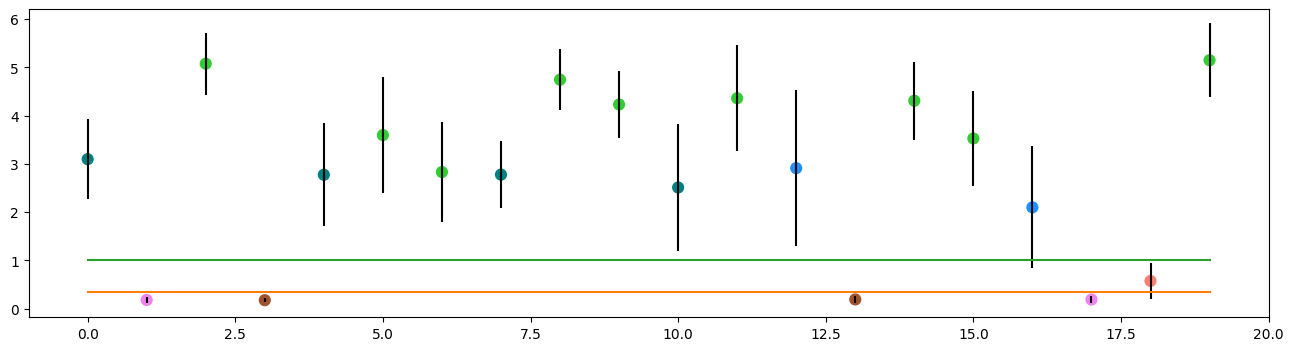

In [12]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [13]:
state_labels = ['I','I2','I3','U','B1','B2']

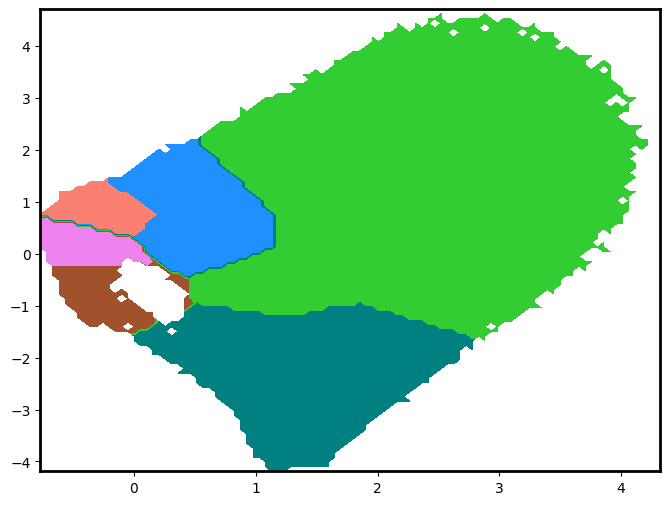

In [14]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [15]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.03538394247865088
1 0.04641144272475492
2 0.07832783846450665
3 0.11821992421159297
4 0.18543424902738836
5 0.5362226030931063


In [16]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 0.1588953345478092 0.07010564942406801
0 2 0.32568694084891786 0.1061324915653834
0 3 0.2508854161731412 0.09795938582705997
0 4 0.03523922601261668 0.0748997091928285
0 5 0.018910002654623424 0.06930912413506934
1 2 0.17366866169784498 0.04241031027403703
1 3 0.09605861828263913 0.0311116783256099
1 4 0.08254620564693681 0.21040202872965022
1 5 0.06774491195709528 0.20672431368088043
2 3 0.011996938670371214 0.06949130143748414
2 4 0.11441974726796908 0.37369250524583264
2 5 0.10038909241906643 0.3708759429232849
3 4 0.10798911658060757 0.3003771121580025
3 5 0.09361330515800652 0.2972086414171701
4 5 0.004133000378605983 0.015555914799958343


In [17]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

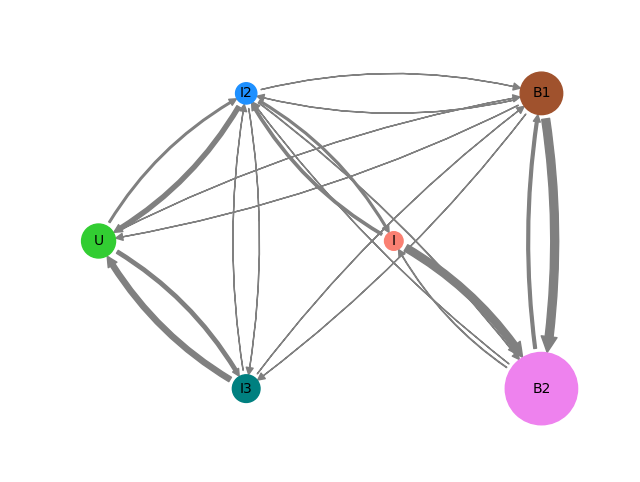

In [18]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[2,0],[1,1],[1,-1],[0,0],[3,1],[3,-1]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [19]:
flux = msm.tpt(model, mdis[3], mdis[5])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.83232336 0.30676158 0.01500276 0.99602373 1.        ]
[0 2 1 5] 0.6983454799275939
[0 2 5] 0.24293038151806948
[0 3 4 5] 0.051761122264797295
[0 4 5] 0.006963016289539271


In [22]:
fid=get_frames(model, mdis, dtrj, stds)
fid

([128, 1, 1, 1, 4, 0],
 [array([    0,     1,     2, ...,  9998,  9999, 10000]),
  array([  2798,   2799,   2800, ..., 317733, 317734, 317754]),
  array([  3379,   6227,   6231, ..., 322054, 322055, 322057]),
  array([   151,    152,    178, ..., 317424, 317425, 317426]),
  array([ 63146,  63147,  63148, ..., 169593, 169594, 169595]),
  array([ 56701,  59355,  59356, ..., 394153, 394157, 394159])])

In [26]:
for i in zip(fid[0], fid[1], ['max','variable','variable','variable','min', 'min'], ['int','i2','i3','unbound', 'b1', 'b2']):
    write_frames(path=path, pdb=pdb, trajs=trajs, idata=idata,
                tid=i[0], fid=i[1], nconfs=20, otype=i[2], sel='all',
                opath='saved_MSM6/', oname=i[3])

/home/msahil/softwares/miniconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/home/msahil/softwares/miniconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1198: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


### bad ones

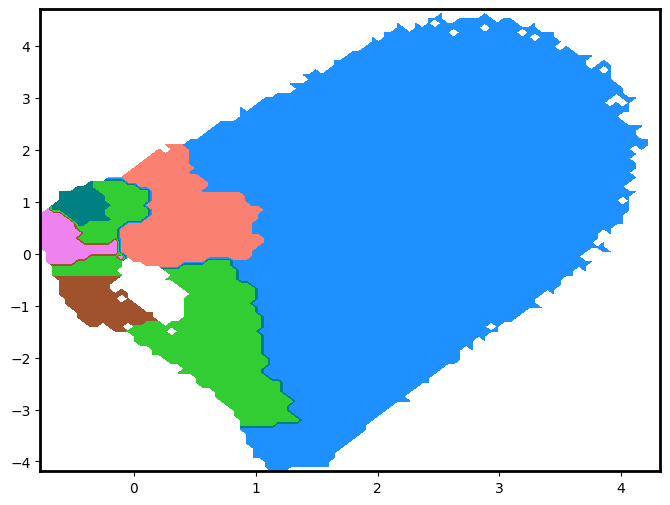

In [33]:
h=2
i=3
cl=150
ml=40
pc=6

tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets

fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

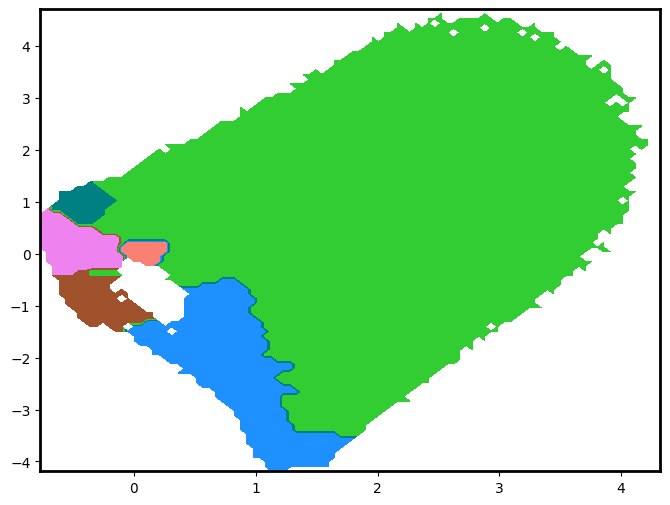

In [34]:
h=2
i=3
cl=250
ml=30
pc=6

tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets

fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

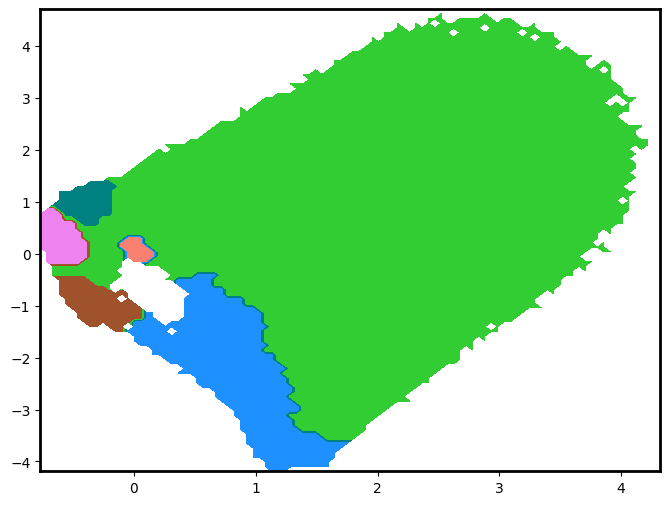

In [35]:
h=2
i=3
cl=1000
ml=20
pc=6

tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets

fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()